In [1]:
import numpy as np
import ROOT as r
import sys,math,array,os
import matplotlib.pyplot as plt
r.gROOT.Macro(os.path.expanduser('~/.rootlogon_nystyle.C'))

Welcome to JupyROOT 6.12/07


0L

# load bunch of numpy arrays

In [3]:
sigaeloss_bb  = np.load('../data/sigaeloss_bb1.npy')
sigaeloss_bkg = np.load('../data/sigaeloss_bkg.npy')
mass_bb       = np.load('../data/mass_bb1.npy')
mass_bkg      = np.load('../data/mass_bkg.npy')
bkgaeloss_bb  = np.load('../data/bkgaeloss_bb1.npy')
bkgaeloss_bkg = np.load('../data/bkgaeloss_bkg.npy')

In [4]:
############### DEFAULT CUT ##############
sigae_wp = .65
bkgae_wp = 2

In [48]:
############### BB1 Alternate CUT ##############
sigae_wp = .6
bkgae_wp = 1.5

In [49]:
index_bb, = np.where((bkgaeloss_bb>bkgae_wp)&(sigaeloss_bb<sigae_wp))[0]
index_bkg, = np.where((bkgaeloss_bkg>bkgae_wp)&(sigaeloss_bkg<sigae_wp))[0]

print(index_bb.shape[0])
print(index_bkg.shape[0])

5154
5450


In [50]:
bins = np.linspace(1000,8000,71,dtype=np.int16)
print(bins)

[1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300
 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700
 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100
 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500
 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900
 8000]


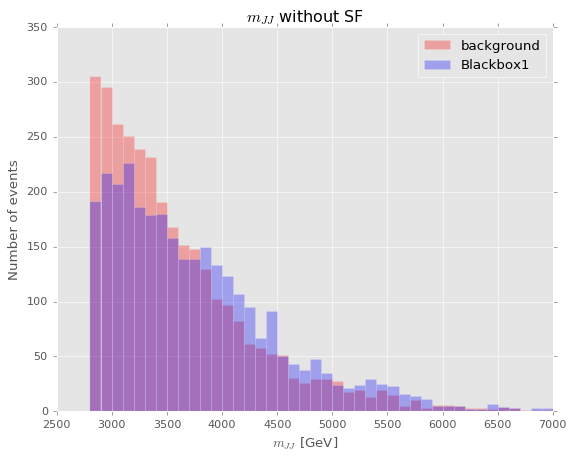

In [52]:
#### Without Scalefactor
#PLOT FOR BLACK BOX 1 with REALNVP
plt.style.use('ggplot')
bins = np.linspace(2800,7000,43)
bkg_hist = plt.hist(mass_bkg[index_bkg],bins=bins,alpha=0.3,color='r',label='background');
obs_hist = plt.hist(mass_bb[index_bb],bins=bins,alpha=0.3,color='b',label='Blackbox1');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
plt.show()
#plt.axvline(x=38238
#plt.savefig("/data/t3home000/spark/LHCOlympics/plots/NEW_BB3_mjj_massratios_noscalefactor_1dot8_0dot5.png")
# plt.savefig("AnalysisBB2/bkgAEcut_mjj_noscalefactor.png")

# Do a parametric fit to data

In [53]:
# Observable
mjj = r.RooRealVar("mjj","m_{JJ} [GeV]", 2800,7000)

In [54]:
# Parameters
sigmean  = r.RooRealVar("sigmean" , "X_{BB} mass" ,  4000, 3000, 7000)
sigwidth = r.RooRealVar("sigwidth", "X_{BB} width",  400, 10, 2000) 

In [55]:
# Build Gaussian PDF
signalModel = r.RooGaussian("signal","signal PDF",mjj,sigmean,sigwidth)

In [56]:
print(mjj)

<ROOT.RooRealVar object ("mjj") at 0xaf04780>


In [11]:
# Build Background PDF with ATLAS Dijet background fit
#p0 = r.RooRealVar("p0","p0",100,-2000,2000)
#p1 = r.RooRealVar("p1","p1",1,-2000,100)
#p2 = r.RooRealVar("p2","p2",1,-2000,100)
#p3 = r.RooRealVar("p3","p3",1,-2000,100)
#background = r.RooGenericPdf("background","background","(pow(1-mjj,p1))/pow(mjj,(p2+p3*log(mjj)))",r.RooArgList(mjj,p1,p2,p3))

In [57]:
# Build Background PDF with ATLAS Dijet background fit
p0 = r.RooRealVar("p0","p0",-0.02,-100,100)
p1 = r.RooRealVar("p1","p1",0.5,-100,100)
p2 = r.RooRealVar("p2","p2",0.1,-100,100)
p3 = r.RooRealVar("p3","p3",0.1,-100,100)
#p4 = r.RooRealVar("p4","p4",0.1,-2000,2000)
background = r.RooPolynomial("background","background",mjj,r.RooArgList(p0,p1,p2,p3))

In [58]:
# Construct Signal + Background PDFs 
nsig = r.RooRealVar("nsig","#signal events",10,0.,10000)
nbkg = r.RooRealVar("nbkg","#background events",800,0.,10000)
model = r.RooAddPdf("model","g+b",r.RooArgList(signalModel,background),r.RooArgList(nsig,nbkg))

In [61]:
#prepare data
roothist_obs = r.TH1F('data_obs','data_obs',42,2800,7000)
roothist_bkg = r.TH1F('purebkg','purebkg',42,2800,7000)
for i in range(0,42):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])


Warning in <TROOT::Append>: Replacing existing TH1: data_obs (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: purebkg (Potential memory leak).


In [62]:
data = r.RooDataHist("data","data",r.RooArgList(mjj),roothist_obs)
bkg = r.RooDataHist("bkg","bkg",r.RooArgList(mjj),roothist_bkg)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable mjj expanded to nearest bin boundaries: [2800,7000] --> [2800,7000]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bkg): fit range of variable mjj expanded to nearest bin boundaries: [2800,7000] --> [2800,7000]


In [ ]:
background.fitTo(bkg)

In [17]:
mjjframe = mjj.frame()

In [ ]:
data.plotOn(mjjframe)

In [ ]:
bkg.plotOn(mjjframe)

In [ ]:
c = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
mjjframe.Draw()

c.Draw()

# Start Generating Shapes for the Fit

In [ ]:
function_gaus = r.TF1("mygaus","TMath::Gaus(x,3823,200)",1000,8000)
roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_sig.FillRandom("mygaus",10000)

In [ ]:
lDM = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
x    = rt.RooRealVar   ("x" ,"x", 0.0   ,1000  ,8000)
mean = rt.RooRealVar("mean",'mean',3823,1000,8000)
sigma = rt.RooRealVar("sigma",'sigma',200,0,500)

In [ ]:
iDataHist = rt.RooDataHist("inputdata","inputdata",rt.RooArgList(x),roothist_sig)

In [ ]:
lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
lVar    = iDataHist.createHistogram("x").GetMean()
lInt    = iDataHist.createHistogram("x").Integral()

In [ ]:
iVar = rt.RooRealVar("x","x",3600,1000,8000)
lShift  = rt.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),rt.RooArgList(iVar,lDM))  